<a href="https://colab.research.google.com/github/ViktorJOlah/Neuro_ANN/blob/main/top%20layer%20encoders/VSD_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is for testing purposes, for getting the most out of GPU

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=dfdf0975d457df8206af7430e777016baa1ac2b431500e91c5858e677c73a653
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.3 GB  | Proc size: 95.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB
Mounted at /content/drive


In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LocallyConnected1D

from keras.models import Sequential
from tensorflow.keras import regularizers



import keras

import tensorflow as tf

import random

import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
params = {
    "batch_size": 64,
    "epochs": 1,
    "lr": 0.0010000,
    "time_steps": 1024,
    "rec_length": 20000
}


TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
steps_per_epoch = 2000

In [ ]:
data = np.load('/content/drive/My Drive/DNN/ANN_revision/VSD/vm.npy')
mean1 = np.mean(data)
sd1 = np.std(data)
data = (data-mean1)/sd1

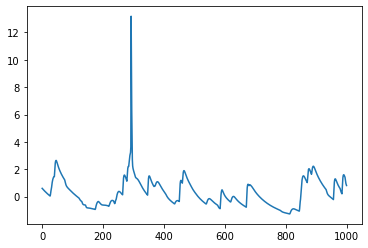

In [ ]:
plt.plot(data[3000:4000])

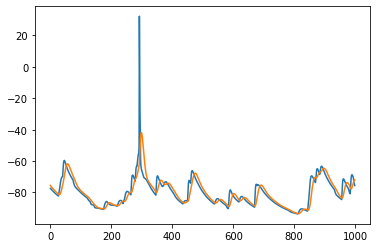

In [ ]:
from scipy import signal
sos = signal.cheby2(2, 10, 3000, 'lp', fs=100000, output='sos')
sos = signal.butter(2, 15, 'lp', fs=500, output='sos')
filtered = signal.sosfilt(sos, data)
plt.plot(data[3000:4000])
plt.plot(filtered[3000:4000])

In [ ]:
#np.save('/content/drive/My Drive/DNN/ANN_revision/VSD/vm_filtered.npy',filtered)

In [ ]:
filtered = np.load('/content/drive/My Drive/DNN/ANN_revision/VSD/vm_filtered.npy')
filtered = (filtered-mean1)/sd1

In [ ]:
x_vm_dim0 = data.shape[0]-TIME_STEPS-10

rand_x_train = random.sample(range(x_vm_dim0), int(x_vm_dim0*0.9))
rand_x_test = np.setdiff1d(range(x_vm_dim0), rand_x_train)

In [ ]:

def gen1(df_vm, df_gcamp, rand_vec, TIME_STEPS, BATCH_SIZE):
    dim_0 = df_vm.shape[0] - TIME_STEPS
    x = np.zeros((BATCH_SIZE, 1, TIME_STEPS))
    y = np.zeros((BATCH_SIZE, TIME_STEPS))
    try:
        place = int(len(rand_vec)*random.random())
        randvec = rand_vec[place:place+BATCH_SIZE]
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[randvec[i]:TIME_STEPS+randvec[i]], [1,1024])
            y[i] = df_gcamp[randvec[i]:TIME_STEPS+randvec[i]]
    except:
        for i in range(BATCH_SIZE):
            x[i] = np.reshape(df_vm[:TIME_STEPS], [1,1024])
            y[i] = np.reshape(df_gcamp[:TIME_STEPS], [1,1024])

    yield x, y





x_train_counter = tf.data.Dataset.from_generator(gen1, args=[filtered, data, rand_x_train, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,1024), (64,1024)) ).repeat().prefetch(tf.data.experimental.AUTOTUNE)
x_test_counter = tf.data.Dataset.from_generator(gen1, args=[filtered, data, rand_x_test, TIME_STEPS, BATCH_SIZE], output_types=(tf.float16, tf.float16), output_shapes = ((64,1,1024), (64,1024)) ).repeat(count=500).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
x1, y1 = next(gen1(filtered, data, rand_x_train, TIME_STEPS, BATCH_SIZE))

In [ ]:
x1.shape

(64, 1, 1024)

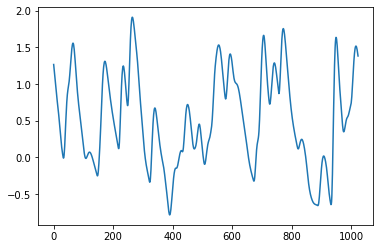

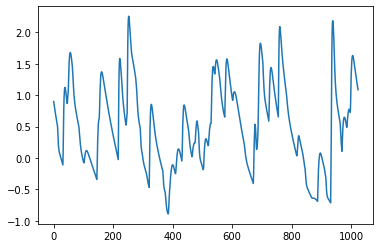

In [ ]:
plt.plot(x1[0][0])
plt.show() 
plt.plot(y1[0])

In [ ]:
def create_model():

    encoder_input = keras.Input(shape=(1,1024))
    x = tf.keras.layers.LSTM(512, return_sequences=True)(encoder_input)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    #x = tf.keras.layers.RepeatVector(10)(x)
    x = tf.keras.layers.LSTM(512, return_sequences=True)(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1024, activation="selu"))(x)
    encoder_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=False))(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")

    encoder.compile(loss='mse', optimizer='Nadam')
    return encoder


model = create_model()
model.summary()

#model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/VSC/weights.378-0.003432-gcamp_deconvolution')

filepath = "weights.{epoch:02d}-{loss:.6f}-VSD_deconvolution"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=50, min_delta=0.0001)
    
mcp = ModelCheckpoint(f"/content/drive/My Drive/DNN/ANN_revision/VSC/{filepath}", monitor='val_loss', verbose=1,
                        save_best_only=True, save_weights_only=False, mode='min', period=1)

# Not used here. But leaving it here as a reminder for future
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, 
                                verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    
history = model.fit(x_train_counter, epochs=50000, steps_per_epoch = 5000, verbose=1, batch_size=64,
                    shuffle=False, validation_data=x_test_counter, validation_steps=400, use_multiprocessing=False, callbacks=[es, mcp, r_lr_plat])


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1024)]         0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3147776   
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 1, 512)            1574912   
                                                                 
 time_distributed (TimeDistr  (None, 1, 1024)          525312    
 ibuted)                                                         
                                                                 
 lambda (Lambda)             (None, 1024)              0         
                                                           

Epoch 1/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.1594
Epoch 1: val_loss improved from inf to 0.11136, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.01-0.159405-VSD_deconvolution


5000/5000 [==============================] - 64s 11ms/step - loss: 0.1594 - val_loss: 0.1114 - lr: 0.0010
Epoch 2/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0877
Epoch 2: val_loss improved from 0.11136 to 0.07503, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.02-0.087734-VSD_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0877 - val_loss: 0.0750 - lr: 0.0010
Epoch 3/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0710
Epoch 3: val_loss improved from 0.07503 to 0.06627, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.03-0.070957-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0710 - val_loss: 0.0663 - lr: 0.0010
Epoch 4/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0588
Epoch 4: val_loss improved from 0.06627 to 0.05100, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.04-0.058758-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0588 - val_loss: 0.0510 - lr: 0.0010
Epoch 5/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0507
Epoch 5: val_loss improved from 0.05100 to 0.04426, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.05-0.050677-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0507 - val_loss: 0.0443 - lr: 0.0010
Epoch 6/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 6: val_loss did not improve from 0.04426
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0452 - val_loss: 0.0456 - lr: 0.0010
Epoch 7/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0416
Epoch 7: val_loss improved from 0.04426 to 0.03763, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.07-0.041574-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0416 - val_loss: 0.0376 - lr: 0.0010
Epoch 8/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0391
Epoch 8: val_loss did not improve from 0.03763
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0391 - val_loss: 0.0402 - lr: 0.0010
Epoch 9/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0375
Epoch 9: val_loss did not improve from 0.03763
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0375 - val_loss: 0.0380 - lr: 0.0010
Epoch 10/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0359
Epoch 10: val_loss improved from 0.03763 to 0.03430, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.10-0.035866-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0359 - val_loss: 0.0343 - lr: 0.0010
Epoch 11/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0347
Epoch 11: val_loss did not improve from 0.03430
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0347 - val_loss: 0.0352 - lr: 0.0010
Epoch 12/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0336
Epoch 12: val_loss did not improve from 0.03430
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0336 - val_loss: 0.0354 - lr: 0.0010
Epoch 13/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0326
Epoch 13: val_loss improved from 0.03430 to 0.03269, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.13-0.032630-VSD_deconvolution


5000/5000 [==============================] - 52s 10ms/step - loss: 0.0326 - val_loss: 0.0327 - lr: 0.0010
Epoch 14/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0319
Epoch 14: val_loss improved from 0.03269 to 0.03260, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.14-0.031910-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0319 - val_loss: 0.0326 - lr: 0.0010
Epoch 15/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0312
Epoch 15: val_loss improved from 0.03260 to 0.03031, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.15-0.031181-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0312 - val_loss: 0.0303 - lr: 0.0010
Epoch 16/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0308
Epoch 16: val_loss improved from 0.03031 to 0.02822, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.16-0.030770-VSD_deconvolution


5000/5000 [==============================] - 55s 11ms/step - loss: 0.0308 - val_loss: 0.0282 - lr: 0.0010
Epoch 17/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0303
Epoch 17: val_loss did not improve from 0.02822
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0303 - val_loss: 0.0311 - lr: 0.0010
Epoch 18/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0299
Epoch 18: val_loss did not improve from 0.02822
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0299 - val_loss: 0.0307 - lr: 0.0010
Epoch 19/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0292
Epoch 19: val_loss did not improve from 0.02822
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0292 - val_loss: 0.0286 - lr: 0.0010
Epoch 20/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0289
Epoch 20: val_loss did not improve from 0.02822
5000/5000 [==============================] - 43s 8ms/st

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0285 - val_loss: 0.0274 - lr: 0.0010
Epoch 22/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0281
Epoch 22: val_loss did not improve from 0.02743
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0281 - val_loss: 0.0281 - lr: 0.0010
Epoch 23/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0279
Epoch 23: val_loss did not improve from 0.02743
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0279 - val_loss: 0.0275 - lr: 0.0010
Epoch 24/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0276
Epoch 24: val_loss improved from 0.02743 to 0.02609, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.24-0.027640-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0276 - val_loss: 0.0261 - lr: 0.0010
Epoch 25/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0273
Epoch 25: val_loss did not improve from 0.02609
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0273 - val_loss: 0.0270 - lr: 0.0010
Epoch 26/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0270
Epoch 26: val_loss improved from 0.02609 to 0.02605, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.26-0.026975-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0270 - val_loss: 0.0260 - lr: 0.0010
Epoch 27/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0269
Epoch 27: val_loss did not improve from 0.02605
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0269 - val_loss: 0.0285 - lr: 0.0010
Epoch 28/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0266
Epoch 28: val_loss did not improve from 0.02605
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0266 - val_loss: 0.0287 - lr: 0.0010
Epoch 29/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0264
Epoch 29: val_loss did not improve from 0.02605
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0264 - val_loss: 0.0280 - lr: 0.0010
Epoch 30/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0262
Epoch 30: val_loss did not improve from 0.02605
5000/5000 [==============================] - 42s 8ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0254 - val_loss: 0.0253 - lr: 0.0010
Epoch 36/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0253
Epoch 36: val_loss did not improve from 0.02529
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0253 - val_loss: 0.0277 - lr: 0.0010
Epoch 37/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0251
Epoch 37: val_loss improved from 0.02529 to 0.02479, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.37-0.025084-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0251 - val_loss: 0.0248 - lr: 0.0010
Epoch 38/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0250
Epoch 38: val_loss improved from 0.02479 to 0.02478, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.38-0.024972-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0250 - val_loss: 0.0248 - lr: 0.0010
Epoch 39/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0247
Epoch 39: val_loss did not improve from 0.02478
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0247 - val_loss: 0.0255 - lr: 0.0010
Epoch 40/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0246
Epoch 40: val_loss improved from 0.02478 to 0.02396, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.40-0.024626-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0246 - val_loss: 0.0240 - lr: 0.0010
Epoch 41/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0245
Epoch 41: val_loss did not improve from 0.02396
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0245 - val_loss: 0.0272 - lr: 0.0010
Epoch 42/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0244
Epoch 42: val_loss did not improve from 0.02396
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0244 - val_loss: 0.0253 - lr: 0.0010
Epoch 43/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0244
Epoch 43: val_loss did not improve from 0.02396
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0244 - val_loss: 0.0256 - lr: 0.0010
Epoch 44/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 44: val_loss did not improve from 0.02396
5000/5000 [==============================] - 44s 9ms/st

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0238 - val_loss: 0.0234 - lr: 0.0010
Epoch 48/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 48: val_loss improved from 0.02335 to 0.02236, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.48-0.023637-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0236 - val_loss: 0.0224 - lr: 0.0010
Epoch 49/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0235
Epoch 49: val_loss did not improve from 0.02236
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0235 - val_loss: 0.0231 - lr: 0.0010
Epoch 50/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0234
Epoch 50: val_loss did not improve from 0.02236
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0234 - val_loss: 0.0257 - lr: 0.0010
Epoch 51/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 51: val_loss did not improve from 0.02236
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0233 - val_loss: 0.0244 - lr: 0.0010
Epoch 52/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 52: val_loss did not improve from 0.02236
5000/5000 [==============================] - 43s 9ms/st

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0228 - val_loss: 0.0223 - lr: 0.0010
Epoch 58/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 58: val_loss improved from 0.02230 to 0.02219, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.58-0.022727-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0227 - val_loss: 0.0222 - lr: 0.0010
Epoch 59/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0226
Epoch 59: val_loss did not improve from 0.02219
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0226 - val_loss: 0.0230 - lr: 0.0010
Epoch 60/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0224
Epoch 60: val_loss did not improve from 0.02219
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0224 - val_loss: 0.0233 - lr: 0.0010
Epoch 61/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0224
Epoch 61: val_loss improved from 0.02219 to 0.02034, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.61-0.022357-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0224 - val_loss: 0.0203 - lr: 0.0010
Epoch 62/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0222
Epoch 62: val_loss did not improve from 0.02034
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0222 - val_loss: 0.0237 - lr: 0.0010
Epoch 63/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0222
Epoch 63: val_loss did not improve from 0.02034
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0222 - val_loss: 0.0240 - lr: 0.0010
Epoch 64/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0221
Epoch 64: val_loss did not improve from 0.02034
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0221 - val_loss: 0.0236 - lr: 0.0010
Epoch 65/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0222
Epoch 65: val_loss did not improve from 0.02034
5000/5000 [==============================] - 43s 9ms/st

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0215 - val_loss: 0.0199 - lr: 0.0010
Epoch 82/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0211
Epoch 82: val_loss did not improve from 0.01987
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0211 - val_loss: 0.0217 - lr: 0.0010
Epoch 83/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0212
Epoch 83: val_loss did not improve from 0.01987
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0212 - val_loss: 0.0225 - lr: 0.0010
Epoch 84/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0211
Epoch 84: val_loss did not improve from 0.01987
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0211 - val_loss: 0.0209 - lr: 0.0010
Epoch 85/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0211
Epoch 85: val_loss did not improve from 0.01987
5000/5000 [==============================] - 43s 9ms/st

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0208 - val_loss: 0.0199 - lr: 0.0010
Epoch 89/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0209
Epoch 89: val_loss did not improve from 0.01986
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0209 - val_loss: 0.0214 - lr: 0.0010
Epoch 90/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 90: val_loss did not improve from 0.01986
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0208 - val_loss: 0.0217 - lr: 0.0010
Epoch 91/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 91: val_loss did not improve from 0.01986
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0208 - val_loss: 0.0210 - lr: 0.0010
Epoch 92/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0207
Epoch 92: val_loss improved from 0.01986 to 0.01983, saving model to /content/drive/My Drive/DNN/ANN_re

5000/5000 [==============================] - 53s 11ms/step - loss: 0.0207 - val_loss: 0.0198 - lr: 0.0010
Epoch 93/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 93: val_loss improved from 0.01983 to 0.01972, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.93-0.020792-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0208 - val_loss: 0.0197 - lr: 0.0010
Epoch 94/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0207
Epoch 94: val_loss did not improve from 0.01972
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0207 - val_loss: 0.0224 - lr: 0.0010
Epoch 95/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0207
Epoch 95: val_loss did not improve from 0.01972
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0207 - val_loss: 0.0208 - lr: 0.0010
Epoch 96/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0206
Epoch 96: val_loss did not improve from 0.01972
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0206 - val_loss: 0.0209 - lr: 0.0010
Epoch 97/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0206
Epoch 97: val_loss did not improve from 0.01972
5000/5000 [==============================] - 43s 9ms/st

5000/5000 [==============================] - 55s 11ms/step - loss: 0.0204 - val_loss: 0.0190 - lr: 0.0010
Epoch 114/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 114: val_loss did not improve from 0.01899
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0201 - val_loss: 0.0193 - lr: 0.0010
Epoch 115/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0201
Epoch 115: val_loss improved from 0.01899 to 0.01872, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.115-0.020129-VSD_deconvolution


5000/5000 [==============================] - 53s 11ms/step - loss: 0.0201 - val_loss: 0.0187 - lr: 0.0010
Epoch 116/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 116: val_loss did not improve from 0.01872
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0201 - val_loss: 0.0206 - lr: 0.0010
Epoch 117/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0203
Epoch 117: val_loss did not improve from 0.01872
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0203 - val_loss: 0.0198 - lr: 0.0010
Epoch 118/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0204
Epoch 118: val_loss did not improve from 0.01872
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0204 - val_loss: 0.0201 - lr: 0.0010
Epoch 119/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0202
Epoch 119: val_loss did not improve from 0.01872
5000/5000 [==============================] - 45

5000/5000 [==============================] - 56s 11ms/step - loss: 0.0174 - val_loss: 0.0180 - lr: 5.0000e-04
Epoch 138/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 138: val_loss improved from 0.01801 to 0.01693, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.138-0.017375-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0174 - val_loss: 0.0169 - lr: 5.0000e-04
Epoch 139/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0173
Epoch 139: val_loss did not improve from 0.01693
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0173 - val_loss: 0.0182 - lr: 5.0000e-04
Epoch 140/50000
4994/5000 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 140: val_loss improved from 0.01693 to 0.01665, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.140-0.017222-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0172 - val_loss: 0.0167 - lr: 5.0000e-04
Epoch 141/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 141: val_loss did not improve from 0.01665
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0172 - val_loss: 0.0188 - lr: 5.0000e-04
Epoch 142/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0171
Epoch 142: val_loss did not improve from 0.01665
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0171 - val_loss: 0.0192 - lr: 5.0000e-04
Epoch 143/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0171
Epoch 143: val_loss did not improve from 0.01665
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0171 - val_loss: 0.0201 - lr: 5.0000e-04
Epoch 144/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 144: val_loss did not improve from 0.01665
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0171 - val_loss: 0.0155 - lr: 5.0000e-04
Epoch 147/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0171
Epoch 147: val_loss did not improve from 0.01551
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0171 - val_loss: 0.0159 - lr: 5.0000e-04
Epoch 148/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0170
Epoch 148: val_loss did not improve from 0.01551
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0170 - val_loss: 0.0182 - lr: 5.0000e-04
Epoch 149/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0171
Epoch 149: val_loss did not improve from 0.01551
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0171 - val_loss: 0.0187 - lr: 5.0000e-04
Epoch 150/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0171
Epoch 150: val_loss did not improve from 0.01551
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0159 - val_loss: 0.0150 - lr: 2.5000e-04
Epoch 169/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0159
Epoch 169: val_loss did not improve from 0.01503
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0159 - val_loss: 0.0163 - lr: 2.5000e-04
Epoch 170/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 170: val_loss did not improve from 0.01503
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0158 - val_loss: 0.0161 - lr: 2.5000e-04
Epoch 171/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 171: val_loss did not improve from 0.01503
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0158 - val_loss: 0.0162 - lr: 2.5000e-04
Epoch 172/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 172: val_loss improved from 0.01503 to 0.01473, saving model to /content/d

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0158 - val_loss: 0.0147 - lr: 2.5000e-04
Epoch 173/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0157
Epoch 173: val_loss did not improve from 0.01473
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0157 - val_loss: 0.0175 - lr: 2.5000e-04
Epoch 174/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0158
Epoch 174: val_loss did not improve from 0.01473
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0158 - val_loss: 0.0163 - lr: 2.5000e-04
Epoch 175/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0157
Epoch 175: val_loss did not improve from 0.01473
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0157 - val_loss: 0.0159 - lr: 2.5000e-04
Epoch 176/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0157
Epoch 176: val_loss did not improve from 0.01473
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0151 - val_loss: 0.0144 - lr: 1.2500e-04
Epoch 196/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0151
Epoch 196: val_loss did not improve from 0.01441
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0151 - val_loss: 0.0149 - lr: 1.2500e-04
Epoch 197/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 197: val_loss improved from 0.01441 to 0.01433, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.197-0.015117-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0151 - val_loss: 0.0143 - lr: 1.2500e-04
Epoch 198/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 198: val_loss did not improve from 0.01433
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0150 - val_loss: 0.0159 - lr: 1.2500e-04
Epoch 199/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 199: val_loss did not improve from 0.01433
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0151 - val_loss: 0.0146 - lr: 1.2500e-04
Epoch 200/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 200: val_loss improved from 0.01433 to 0.01397, saving model to /content/drive/My Drive/DNN/ANN_revision/VSC/weights.200-0.015092-VSD_deconvolution


5000/5000 [==============================] - 54s 11ms/step - loss: 0.0151 - val_loss: 0.0140 - lr: 1.2500e-04
Epoch 201/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 201: val_loss did not improve from 0.01397
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0151 - val_loss: 0.0160 - lr: 1.2500e-04
Epoch 202/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 202: val_loss did not improve from 0.01397
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0151 - val_loss: 0.0150 - lr: 1.2500e-04
Epoch 203/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0151
Epoch 203: val_loss did not improve from 0.01397
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0151 - val_loss: 0.0143 - lr: 1.2500e-04
Epoch 204/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 204: val_loss did not improve from 0.01397
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0150 - val_loss: 0.0137 - lr: 1.2500e-04
Epoch 215/50000
4997/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 215: val_loss did not improve from 0.01373
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0150 - val_loss: 0.0167 - lr: 1.2500e-04
Epoch 216/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 216: val_loss did not improve from 0.01373
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0150 - val_loss: 0.0163 - lr: 1.2500e-04
Epoch 217/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 217: val_loss did not improve from 0.01373
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0150 - val_loss: 0.0152 - lr: 1.2500e-04
Epoch 218/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0149
Epoch 218: val_loss did not improve from 0.01373
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0149 - val_loss: 0.0137 - lr: 1.2500e-04
Epoch 230/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0149
Epoch 230: val_loss did not improve from 0.01369
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0149 - val_loss: 0.0148 - lr: 1.2500e-04
Epoch 231/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0149
Epoch 231: val_loss did not improve from 0.01369
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0149 - val_loss: 0.0154 - lr: 1.2500e-04
Epoch 232/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0149
Epoch 232: val_loss did not improve from 0.01369
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0149 - val_loss: 0.0147 - lr: 1.2500e-04
Epoch 233/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0149
Epoch 233: val_loss did not improve from 0.01369
5000/5000 [====================

5000/5000 [==============================] - 56s 11ms/step - loss: 0.0145 - val_loss: 0.0134 - lr: 3.1250e-05
Epoch 257/50000
4998/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 257: val_loss did not improve from 0.01343
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0145 - val_loss: 0.0154 - lr: 3.1250e-05
Epoch 258/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 258: val_loss did not improve from 0.01343
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0145 - val_loss: 0.0141 - lr: 3.1250e-05
Epoch 259/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 259: val_loss did not improve from 0.01343
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0145 - val_loss: 0.0144 - lr: 3.1250e-05
Epoch 260/50000
4995/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 260: val_loss did not improve from 0.01343
5000/5000 [====================

5000/5000 [==============================] - 54s 11ms/step - loss: 0.0145 - val_loss: 0.0131 - lr: 3.1250e-05
Epoch 264/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0145
Epoch 264: val_loss did not improve from 0.01307
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0145 - val_loss: 0.0145 - lr: 3.1250e-05
Epoch 265/50000
4996/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 265: val_loss did not improve from 0.01307
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0145 - val_loss: 0.0140 - lr: 3.1250e-05
Epoch 266/50000
4999/5000 [============================>.] - ETA: 0s - loss: 0.0145
Epoch 266: val_loss did not improve from 0.01307
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0145 - val_loss: 0.0161 - lr: 3.1250e-05
Epoch 267/50000
5000/5000 [==============================] - ETA: 0s - loss: 0.0145
Epoch 267: val_loss did not improve from 0.01307
5000/5000 [====================

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/DNN/ANN_revision/VSC/weights.263-0.014510-VSD_deconvolution')

@tf.function
def serve_CNN_LSTM(x):
    return model(x, training=False)

In [ ]:
x_t, y_t = next(gen1(filtered, data, rand_x_train, TIME_STEPS, BATCH_SIZE))

In [ ]:
x_t[0].shape

(1, 1024)

In [ ]:
vmi1 = serve_CNN_LSTM(x_t)

(64, 1024)

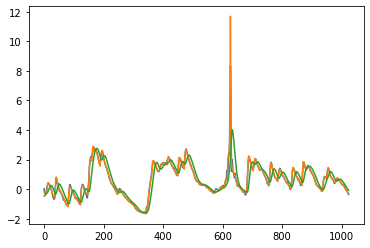

0


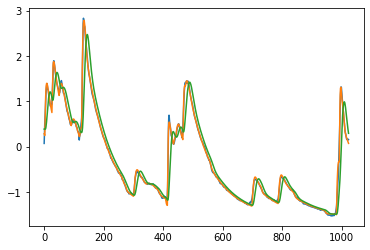

1


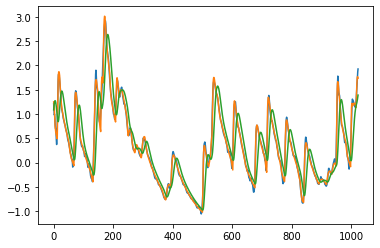

2


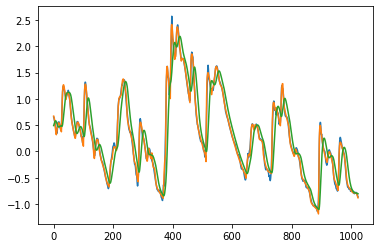

3


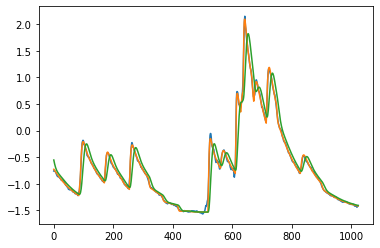

4


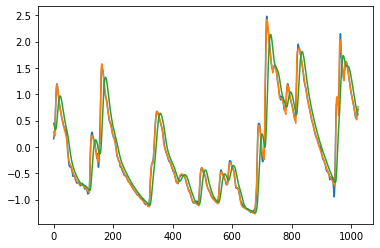

5


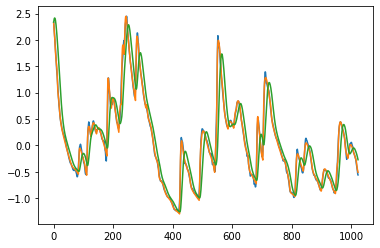

6


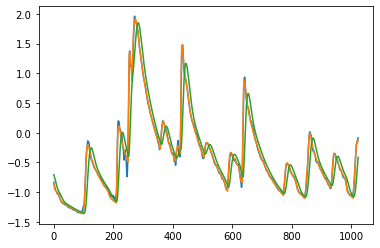

7


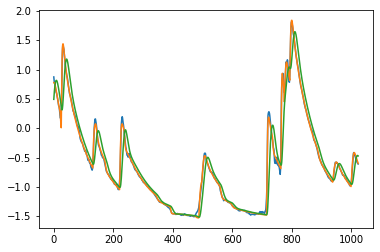

8


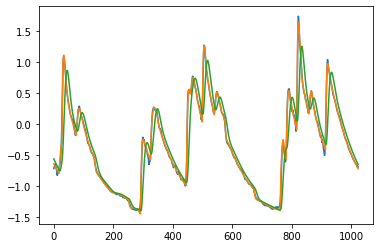

9


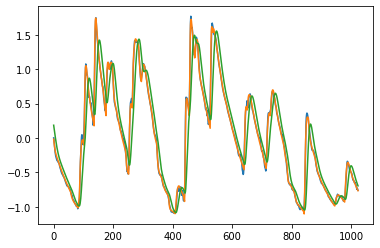

10


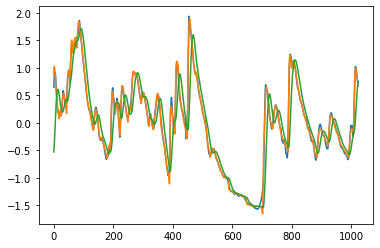

11


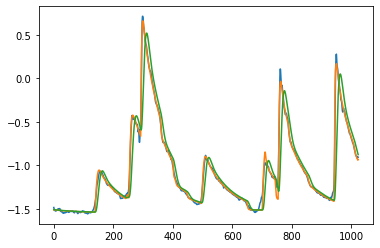

12


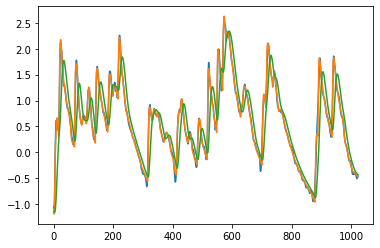

13


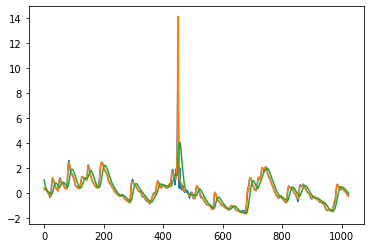

14


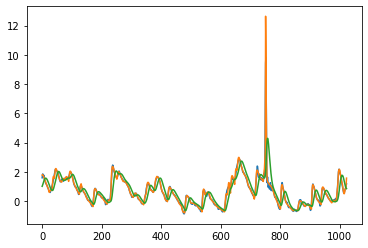

15


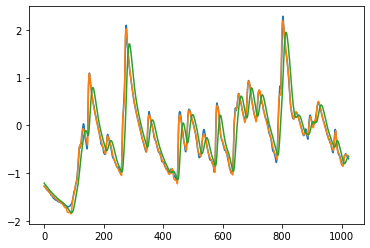

16


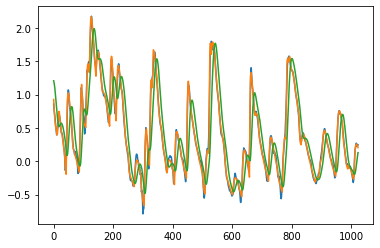

17


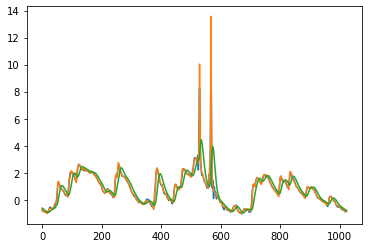

18


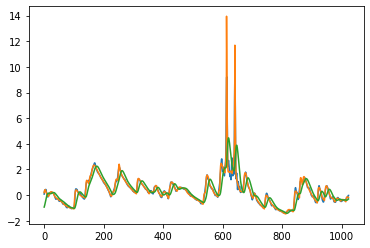

19


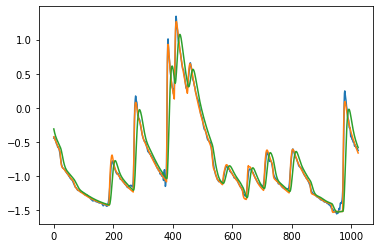

20


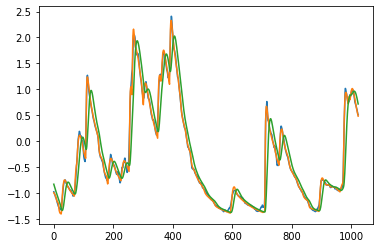

21


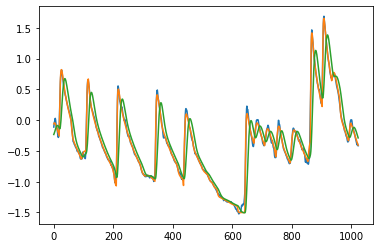

22


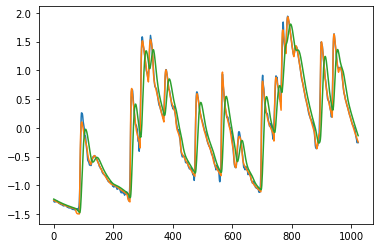

23


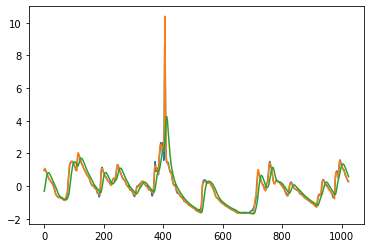

24


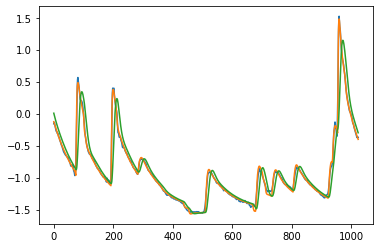

25


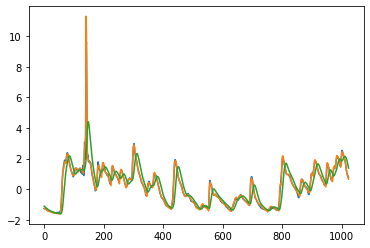

26


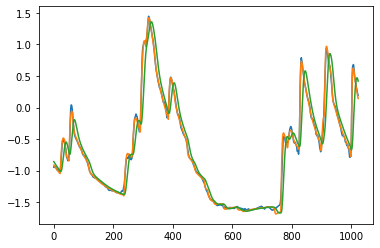

27


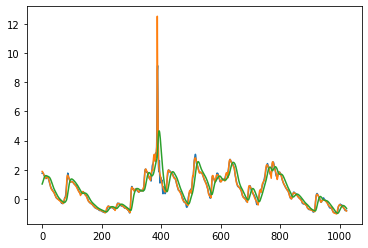

28


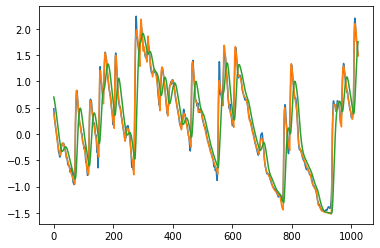

29


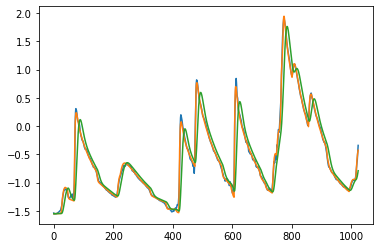

30


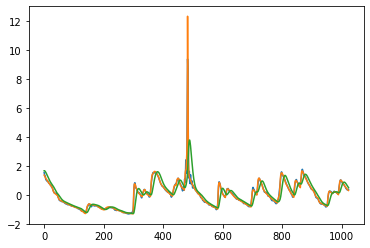

31


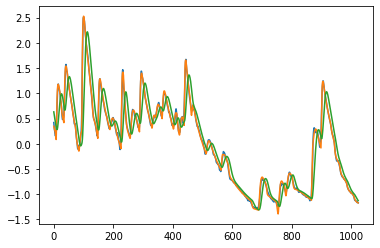

32


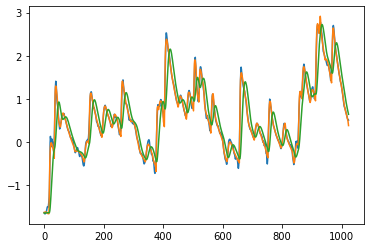

33


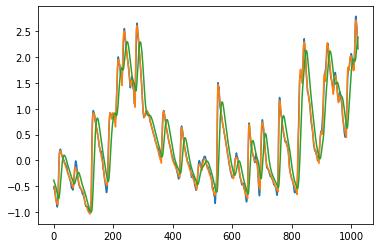

34


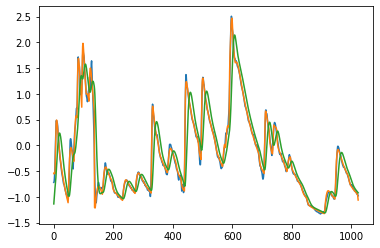

35


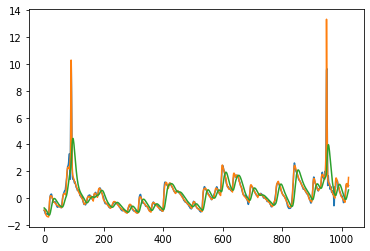

36


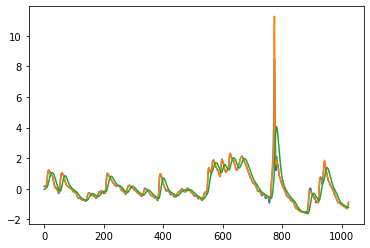

37


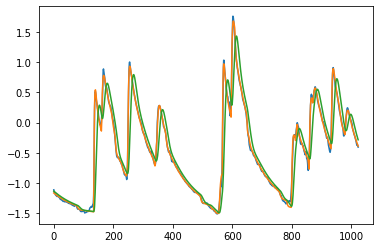

38


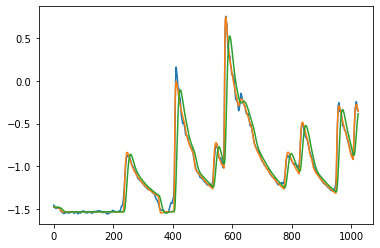

39


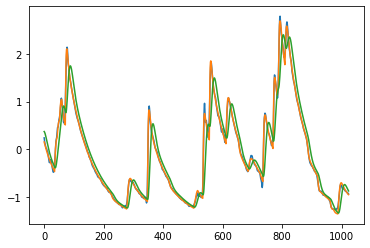

40


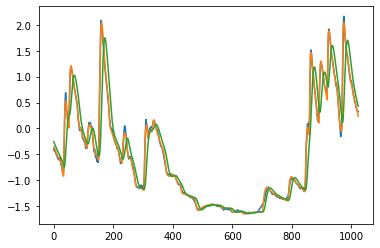

41


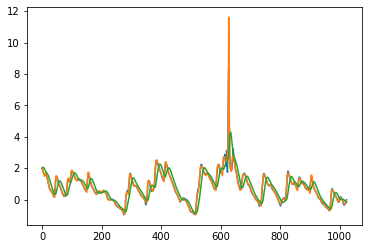

42


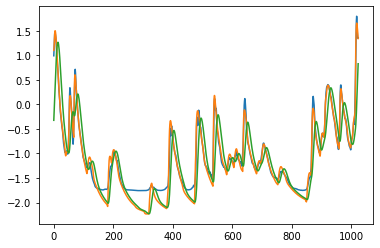

43


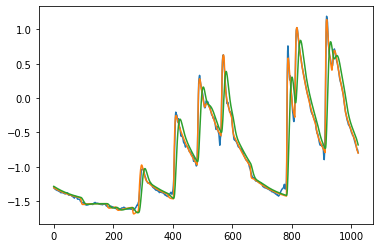

44


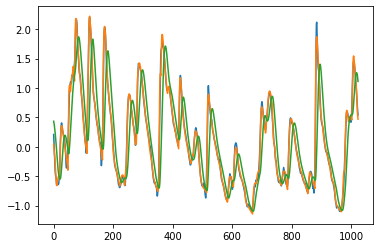

45


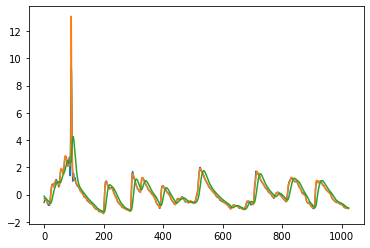

46


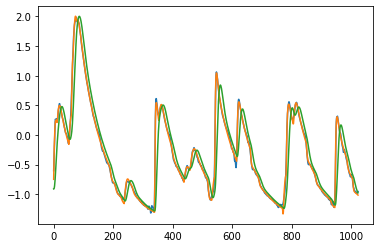

47


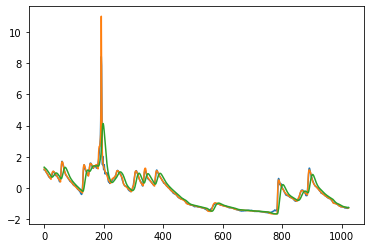

48


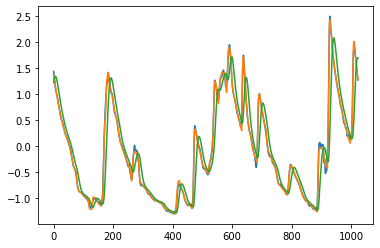

49


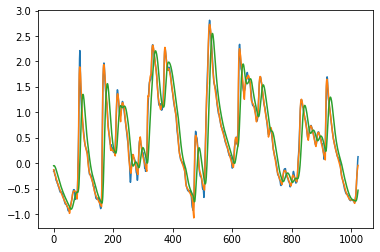

50


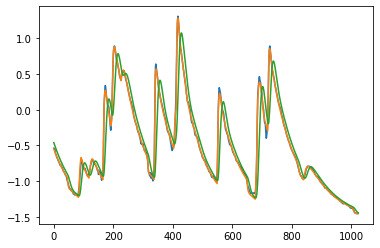

51


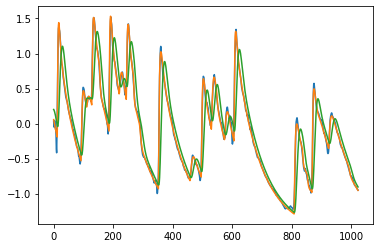

52


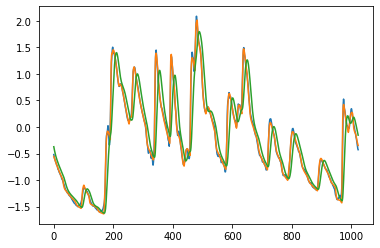

53


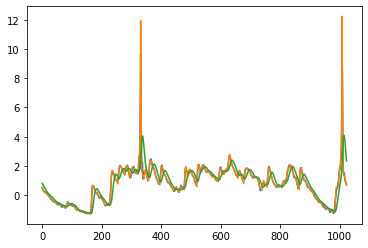

54


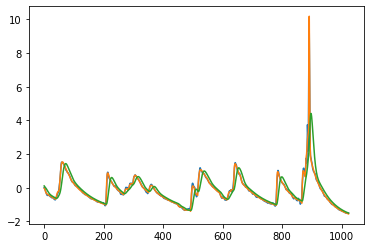

55


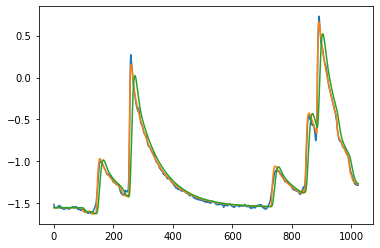

56


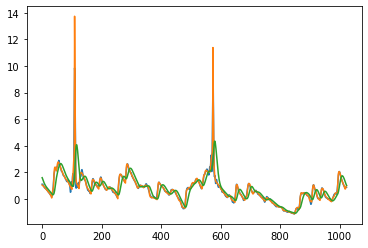

57


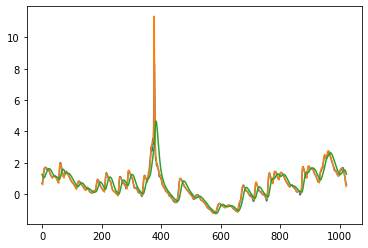

58


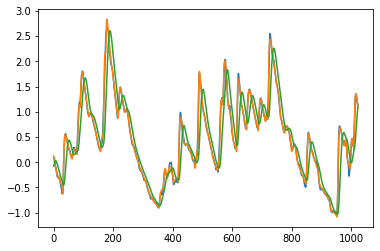

59


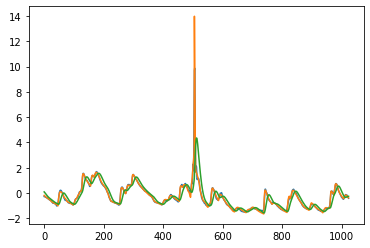

60


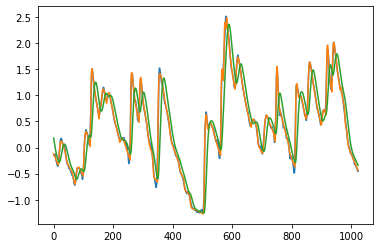

61


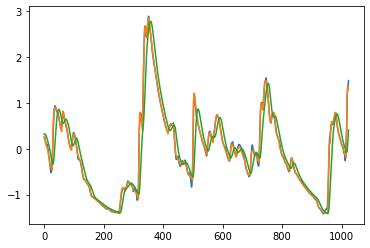

62


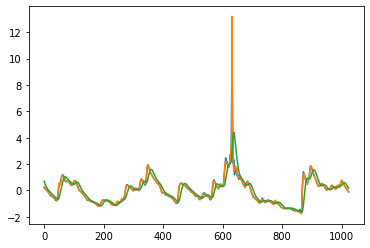

63


In [ ]:
vmi2 = np.asarray(vmi1)
for i in range(64):
    plt.plot(vmi2[i])
    plt.plot(y_t[i])
    plt.plot(x_t[i,0])
    plt.show()
    print(i)


In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/fit_pred.txt',vmi2.flatten(order='C'))
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/fit_GT.txt',y_t.flatten(order='C'))

In [ ]:
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/prediction_pred.txt',vmi2[60])
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/prediction_GT.txt',y_t[60])
np.savetxt('/content/drive/My Drive/DNN/ANN_revision/VSC/prediction_vm.txt',x_t[60,0])

In [ ]:
    plt.plot(vmi2[i])
    plt.plot(y_t[i])
    plt.plot(x_t[i,0])

In [ ]:
#evalute explained variance
for i in range(50):
    mse = np.mean((vmi2[i]-y_t[i])**2)
    var = np.var(y_t[i])
    var_explained = 1-(mse/var)
    if(var>0.01):
        print(var_explained)

0.9880621266431054
0.9944130754516664
0.9902350489384218
0.9946566525478162
0.9516548519926864
0.9922887972621173
0.9897413225015542
0.993646933480572
0.9671153022996208
0.9952045222455204
0.9933426429468106
0.9908434240634925
0.970064375992022
0.9953476615369966
0.9967578453681978
0.9965422982407075
0.9945768140087482
0.9931384513636382
0.9715575830385037
0.9926128494972424
0.9913104340455103
0.9913932871777054
0.9965002536720274
0.9903149819515431
0.9945943140431304
0.9555155366415725
0.9896241720587416
0.9968283061014168
0.9954570385462091
0.9612210894740331
0.9948516047434859
0.9668956136382468
0.996522340062242
0.9953408301471512
0.9906697003520039
0.9721979550680884
0.9959375443382048
0.9812018660848033
0.9951655026399088
0.98632376071765
0.9945955302907262
0.9958813262136339
0.9614429825371431
0.9914147820082043
0.996561251288227
0.9254285920962236
0.9697607537570908
0.9956950575734856
0.9964768391717965
0.9931306284465964


(50, 513)

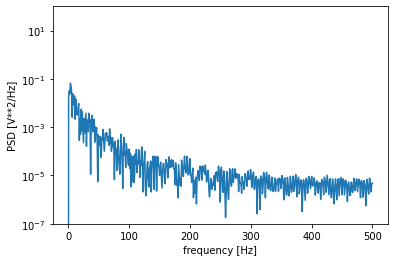

In [ ]:
f, Pxx_den = signal.periodogram(y_t[0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
f

array([  0.       ,   0.9765625,   1.953125 ,   2.9296875,   3.90625  ,
         4.8828125,   5.859375 ,   6.8359375,   7.8125   ,   8.7890625,
         9.765625 ,  10.7421875,  11.71875  ,  12.6953125,  13.671875 ,
        14.6484375,  15.625    ,  16.6015625,  17.578125 ,  18.5546875,
        19.53125  ,  20.5078125,  21.484375 ,  22.4609375,  23.4375   ,
        24.4140625,  25.390625 ,  26.3671875,  27.34375  ,  28.3203125,
        29.296875 ,  30.2734375,  31.25     ,  32.2265625,  33.203125 ,
        34.1796875,  35.15625  ,  36.1328125,  37.109375 ,  38.0859375,
        39.0625   ,  40.0390625,  41.015625 ,  41.9921875,  42.96875  ,
        43.9453125,  44.921875 ,  45.8984375,  46.875    ,  47.8515625,
        48.828125 ,  49.8046875,  50.78125  ,  51.7578125,  52.734375 ,
        53.7109375,  54.6875   ,  55.6640625,  56.640625 ,  57.6171875,
        58.59375  ,  59.5703125,  60.546875 ,  61.5234375,  62.5      ,
        63.4765625,  64.453125 ,  65.4296875,  66.40625  ,  67.3

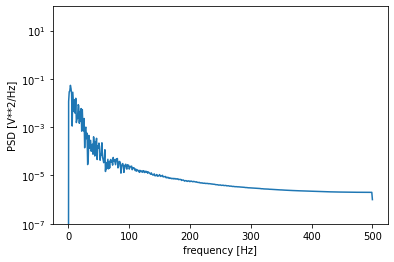

In [ ]:
f, Pxx_den = signal.periodogram(x_t[0,0], fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
f

array([  0.       ,   0.9765625,   1.953125 ,   2.9296875,   3.90625  ,
         4.8828125,   5.859375 ,   6.8359375,   7.8125   ,   8.7890625,
         9.765625 ,  10.7421875,  11.71875  ,  12.6953125,  13.671875 ,
        14.6484375,  15.625    ,  16.6015625,  17.578125 ,  18.5546875,
        19.53125  ,  20.5078125,  21.484375 ,  22.4609375,  23.4375   ,
        24.4140625,  25.390625 ,  26.3671875,  27.34375  ,  28.3203125,
        29.296875 ,  30.2734375,  31.25     ,  32.2265625,  33.203125 ,
        34.1796875,  35.15625  ,  36.1328125,  37.109375 ,  38.0859375,
        39.0625   ,  40.0390625,  41.015625 ,  41.9921875,  42.96875  ,
        43.9453125,  44.921875 ,  45.8984375,  46.875    ,  47.8515625,
        48.828125 ,  49.8046875,  50.78125  ,  51.7578125,  52.734375 ,
        53.7109375,  54.6875   ,  55.6640625,  56.640625 ,  57.6171875,
        58.59375  ,  59.5703125,  60.546875 ,  61.5234375,  62.5      ,
        63.4765625,  64.453125 ,  65.4296875,  66.40625  ,  67.3